In [1]:
import os
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fancyimpute import IterativeImputer as MICE
from fancyimpute import NuclearNormMinimization, SoftImpute

import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras import backend

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
pip install fancyimpute

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 25.8 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 66.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8 MB 65.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 66.8 MB/s eta 0:00:01
     |████████████████████████████████| 164 kB 64.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 66.0 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 62.7 MB/s eta 0:00:01
     |████████████████████████████████| 269 kB 67.5 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 60.2 MB/s eta 0:00:01
  Created wheel for fancyimpute: filename=fancyimpute-0.5.5-py3-none-any.whl size=26455 sha256=2972c91a1599701fca2c43818d7624d2bdf0a192f4b90b59de63fb6355cfec86
  Stored in dir

In [1]:
 pip install keras , sklearn ,pickle ,math, os

Defaulting to user installation because normal site-packages is not writeable
ERROR: Invalid requirement: ','
Note: you may need to restart the kernel to use updated packages.


In [2]:
 pip install keras 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
 pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=210976ca5e3596f4ea6b07b90b4c6a472dd11f7c1af76ed96a873d39a8c6e613
  Stored in directory: /home/mmagai/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pickle 

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.3 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 63.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.6 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 68.2 MB/s eta 0:00:01
     |████████████████████████████████| 92 kB 179 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
def get_grdc(grdc_no):
    data_date_month = []
    data_date_common = []
    data_value = []
    f = open("Europe/" + grdc_no + "_Q_Day.Cmd.txt", "rb")
    for i in f:
        i = str(i)[2:-5]
        if "#" in i:
            continue
        if "YYYY" in i:
            continue
        temp = [i.strip() for i in i.split(";")]
        date_temp = temp[0].split("-")
        date_temp = [i.strip() for i in temp[0].split("-")]
        data_date_month.append(int(date_temp[1]))
        data_date_common.append(date_temp[0] + "-" + date_temp[1] + "-" + date_temp[2])
        data_value.append(round(float(temp[2]), 3))
    df_temp = pd.DataFrame(list(zip(data_date_month, data_value, data_date_common)),
                               columns =["Month", "Value", "Date"])
    df_temp = df_temp.set_index('Date')
    df_temp = df_temp[df_temp["Month"] != 0]
    df_temp.sort_index()
    df_index = df_temp.index
    df_temp.replace(-999.0, np.nan, inplace=True)
    
    return df_temp

In [3]:
def get_data(f):
    
    value = []
    common = []
    
    grdc_no = ""
    latitude = ""
    longitude = ""
    
    for i in f:
        
        i = str(i)[2:-5]
        
        if "GRDC-No" in i:
            grdc_no = i.split(":")[1].strip()
            continue
        elif "Latitude" in i:
            latitude = i.split(":")[1].strip()
            continue
        elif "Longitude" in i:
            longitude = i.split(":")[1].strip()
            continue
        elif "YYYY" in i:
            continue
        elif "#" in i:
            continue

        temp = [i.strip() for i in i.split(";")]
        date_temp = temp[0].split("-")
        date_temp = [i.strip() for i in temp[0].split("-")]
        common.append(date_temp[0] + "-" + date_temp[1] + "-" + date_temp[2])
        if grdc_no == "6338120":
            print(temp)
        
        value.append(round(float(temp[2]), 3))
#     print(grdc_no)    
    return value, common, grdc_no, latitude, longitude

In [4]:
def merged(x, x_ncdc):
    
    x = x.set_index('Date')
    x.sort_index()
    x_ncdc = x_ncdc.set_index('DATE')
    x_ncdc.sort_index()
    
    x_first = x.index[0] if x.index[0] > x_ncdc.index[0] else x_ncdc.index[0]
    x_last = x.index[-1] if x.index[-1] < x_ncdc.index[-1] else x_ncdc.index[-1]
    merged = pd.concat([x, x_ncdc], axis=1, sort=True)
    to_delete = []
    for i, r in merged.iterrows():
        if i < x_first or i > x_last:
            to_delete.append(i)
            
    merged = merged.drop(to_delete)
    
    return merged

In [5]:
all_data = {}

for filename in os.listdir("Europe/"):

    f = open("Europe/" + filename, "rb")
    f2 = pd.read_csv("NCDC/" + filename[:7] + ".csv")

    value, common, grdc_no, latitude, longitude = get_data(f)
    f.close()

    df_temp = pd.DataFrame(list(zip(value, common)), columns =["Value", "Date"])
    df_temp = merged(df_temp, f2)
    df2 = df_temp["Value"]
    df2 = df2.replace(-999.0, np.nan)
    df2 = df2.fillna(df2.mean())
    first_index = df_temp["LONGITUDE"].first_valid_index()
    temp_dict = {
        "GRDC_latitude": latitude,
        "GRDC_longitude": longitude,
        "NCDC_latitude": df_temp["LATITUDE"][first_index],
        "NCDC_longitude": df_temp["LONGITUDE"][first_index],
        "Elevation": df_temp["ELEVATION"][first_index]
    }
    cols = list(df_temp.columns)
    cols_to_keep = []
    for i in cols:
        if len(i) == 4 and i != "NAME":
            cols_to_keep.append(i)
            cols.remove(i)
    df_temp.drop(columns=cols, inplace=True)
    df_temp.sort_index()
    df_index = df_temp.index
    soft_impute = SoftImpute(max_iters=300, verbose=False)
    df_temp = soft_impute.fit_transform(df_temp)
    df_temp = pd.DataFrame(data=df_temp, columns=cols_to_keep)
    if "PRCP" in cols_to_keep:
        df_temp[df_temp["PRCP"] < 0] = 0
    if "SNWD" in cols_to_keep:
        df_temp[df_temp["SNWD"] < 0] = 0
    df_temp["Date"] = df_index
    df_temp = df_temp.set_index(["Date"])
    df_temp["t-1"] = df2.shift(1)
    df_temp = df_temp.replace(np.nan, 0)
    temp_dict["data_x"] = df_temp
    temp_dict["data_y"] = df2
    all_data[grdc_no] = temp_dict  

/software/jupyterhub/env/jupyterhub-user/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


['1900-11-01', '--:--', '35.400']
['1900-11-02', '--:--', '33.300']
['1900-11-03', '--:--', '29.200']
['1900-11-04', '--:--', '26.500']
['1900-11-05', '--:--', '24.000']
['1900-11-06', '--:--', '17.900']
['1900-11-07', '--:--', '17.000']
['1900-11-08', '--:--', '16.300']
['1900-11-09', '--:--', '15.500']
['1900-11-10', '--:--', '15.000']
['1900-11-11', '--:--', '14.600']
['1900-11-12', '--:--', '14.300']
['1900-11-13', '--:--', '12.400']
['1900-11-14', '--:--', '14.300']
['1900-11-15', '--:--', '15.600']
['1900-11-16', '--:--', '16.600']
['1900-11-17', '--:--', '20.000']
['1900-11-18', '--:--', '19.300']
['1900-11-19', '--:--', '19.600']
['1900-11-20', '--:--', '18.800']
['1900-11-21', '--:--', '19.100']
['1900-11-22', '--:--', '21.200']
['1900-11-23', '--:--', '21.000']
['1900-11-24', '--:--', '24.200']
['1900-11-25', '--:--', '24.300']
['1900-11-26', '--:--', '21.800']
['1900-11-27', '--:--', '20.400']
['1900-11-28', '--:--', '21.500']
['1900-11-29', '--:--', '21.500']
['1900-11-30',

In [6]:
all_data

{'6233250': {'GRDC_latitude': '56.1',
  'GRDC_longitude': '14.12',
  'NCDC_latitude': 51.7667,
  'NCDC_longitude': -1.2667,
  'Elevation': 63.0,
  'data_x':             PRCP  TMAX  TMIN    t-1
  Date                               
  1908-01-01  0.00  33.0  31.0   0.00
  1908-01-02  0.00  32.0  26.0  30.00
  1908-01-03  0.00  38.0  21.0  29.00
  1908-01-04  0.00  27.0  21.0  29.00
  1908-01-05  0.00  49.0  21.0  28.00
  ...          ...   ...   ...    ...
  2018-09-22  0.56  58.0  50.0   8.18
  2018-09-23  0.04  61.0  46.0   2.00
  2018-09-24  0.00  64.0  39.0   2.00
  2018-09-25  0.00  72.0  37.0   2.00
  2018-09-26  0.00  74.0  44.0  14.90
  
  [40447 rows x 4 columns],
  'data_y': 1908-01-01    30.0
  1908-01-02    29.0
  1908-01-03    29.0
  1908-01-04    28.0
  1908-01-05    28.0
                ... 
  2018-09-22     2.0
  2018-09-23     2.0
  2018-09-24     2.0
  2018-09-25    14.9
  2018-09-26    14.6
  Name: Value, Length: 40447, dtype: float64},
 '6233780': {'GRDC_latitude': '6

In [8]:
pickle.dump(all_data, open("save_soft_impute.p", "wb"))

In [9]:
all_data = pickle.load(open( "save_soft_impute.p", "rb" ))

In [10]:
new_data_x = all_data["6233250"]["data_x"]
new_data_y = all_data["6233250"]["data_y"]

In [11]:
new_data_x.head()

,PRCP,TMAX,TMIN,t-1
Date,,,,
1908-01-01,0.0,33.0,31.0,0.0
1908-01-02,0.0,32.0,26.0,30.0
1908-01-03,0.0,38.0,21.0,29.0
1908-01-04,0.0,27.0,21.0,29.0
1908-01-05,0.0,49.0,21.0,28.0


In [34]:
new_data_y.shape

(40447,)

In [11]:

new_data_y = np.asarray(new_data_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
new_data_x = scaler.fit_transform(new_data_x)
new_data_y = scaler.fit_transform(new_data_y)
X_train, X_test, y_train, y_test = train_test_split(new_data_x, new_data_y, test_size = 0.20)
X_train = np.asarray(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = np.asarray(y_train)
X_test = np.asarray(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = np.asarray(y_test)

model = Sequential()
model.add(LSTM(8, input_shape=[X_train.shape[1], X_train.shape[2]]))
model.add(Dense(16))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train, y_train ,epochs = 50)

Epoch 1/50
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537
Epoch 2/50
1012/1012 [==============================] - 2s 2ms/step - loss: 5.2638e-04 - root_mean_squared_error: 0.0229
Epoch 3/50
1012/1012 [==============================] - 2s 2ms/step - loss: 5.1513e-04 - root_mean_squared_error: 0.0227
Epoch 4/50
1012/1012 [==============================] - 2s 2ms/step - loss: 5.1623e-04 - root_mean_squared_error: 0.0227
Epoch 5/50
1012/1012 [==============================] - 2s 2ms/step - loss: 5.1924e-04 - root_mean_squared_error: 0.0228
Epoch 6/50
1012/1012 [==============================] - 2s 2ms/step - loss: 5.1114e-04 - root_mean_squared_error: 0.0226
Epoch 7/50
1012/1012 [==============================] - 2s 2ms/step - loss: 5.1253e-04 - root_mean_squared_error: 0.0226
Epoch 8/50
1012/1012 [==============================] - 2s 2ms/step - loss: 5.1212e-04 - root_mean_squared_error: 0.0226
Epoch 9/50
1012/1012 [==============

In [13]:
temp = model.evaluate(X_test,y_test)
print("Loss of the model is - " , temp[0])
print("Accuracy of the model is - " , temp[1]*100)

253/253 [==============================] - 0s 877us/step - loss: 5.1016e-04 - root_mean_squared_error: 0.0226
Loss of the model is -  0.000510161102283746
Accuracy of the model is -  2.2586746141314507


In [34]:
#predicted_y = model.predict(X_test)

In [35]:
#yhat_classes = model.predict_classes(X_test, verbose=0)

In [36]:
#yhat_classes = yhat_classes[:, 0]

In [37]:
#f1 = f1_score(y_test, yhat_classes,normalize=true)

In [14]:
results_train = model.predict(X_train)
results_test = model.predict(X_test)

In [18]:
# 2969101
# 2969100

test_new_x = np.asarray(all_data["6233250"]["data_x"])
test_new_y = np.asarray(all_data["6233250"]["data_y"])

test_new_y = np.asarray(test_new_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_new_x = scaler.fit_transform(test_new_x)
test_new_y = scaler.fit_transform(test_new_y)
test_new_x = test_new_x.reshape((test_new_x.shape[0], test_new_x.shape[1], 1))

results = model.predict(test_new_x)

In [19]:
results

array([[0.0089278 ],
       [0.12141498],
       [0.1143092 ],
       ...,
       [0.0151889 ],
       [0.01393451],
       [0.0615651 ]], dtype=float32)

In [69]:
from matplotlib.pyplot import *

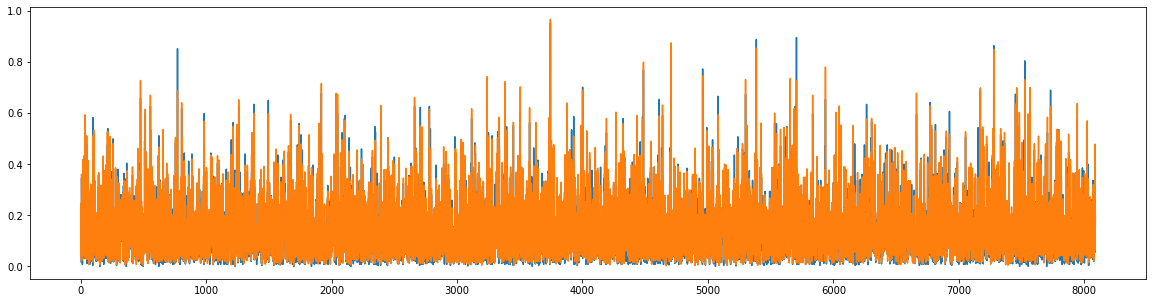

In [20]:
plt.figure(figsize=(20,5))
plt.plot([i for i in range(len(y_test))], y_test)
# plt.plot([i for i in range(len(test_new_y))], test_new_y)
plt.plot([i for i in range(len(results_test))], results_test)
plt.show()

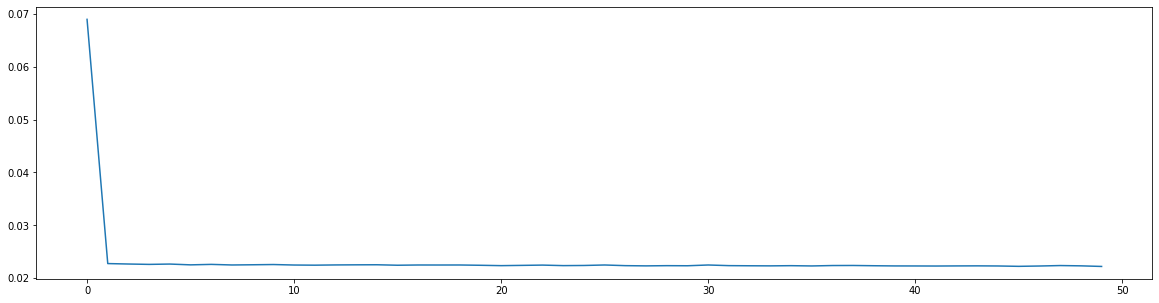

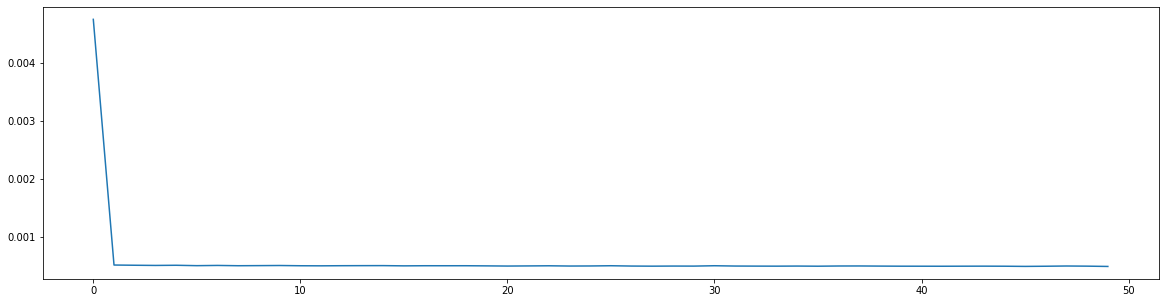

In [71]:
plt.figure(figsize=(20,5))
plt.plot(history.history["root_mean_squared_error"])
plt.figure(figsize=(20,5))
plt.plot(history.history["loss"])
plt.show()

In [72]:
# Second Station

In [96]:
# 2969101
# 2969100

test_new_x = np.asarray(all_data["6233780"]["data_x"])
test_new_y = np.asarray(all_data["6233780"]["data_y"])

test_new_y = np.asarray(test_new_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_new_x = scaler.fit_transform(test_new_x)
test_new_y = scaler.fit_transform(test_new_y)
test_new_x = test_new_x.reshape((test_new_x.shape[0], test_new_x.shape[1], 1))

results = model.predict(test_new_x)

In [97]:
results

array([[0.01072415],
       [0.03911757],
       [0.03656768],
       ...,
       [0.02778663],
       [0.02766469],
       [0.0274313 ]], dtype=float32)

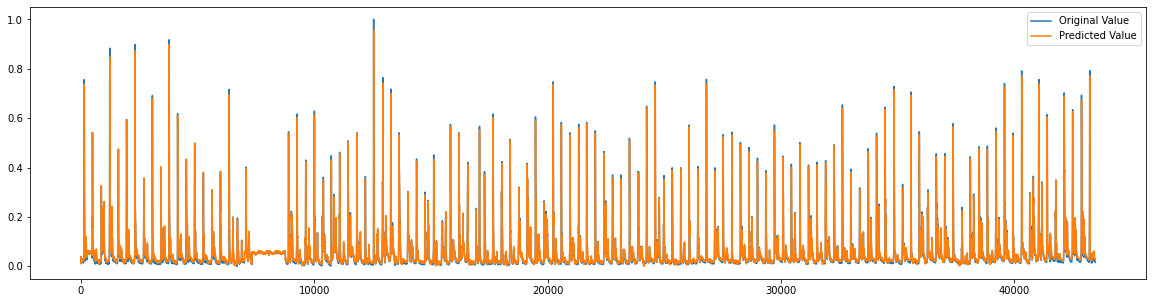

In [98]:
plt.figure(figsize=(20,5))
# plt.plot([i for i in range(len(y_test))], y_test)
plt.plot([i for i in range(len(test_new_y))], test_new_y,label='Original Value')
plt.plot([i for i in range(len(results))], results, label='Predicted Value')
plt.legend()
plt.show()

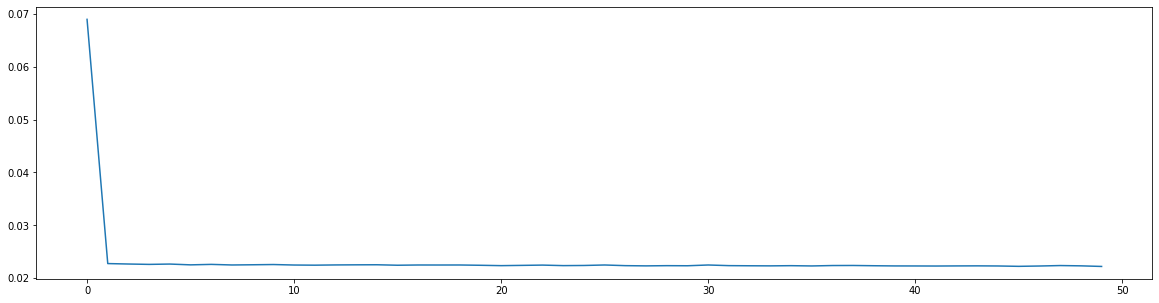

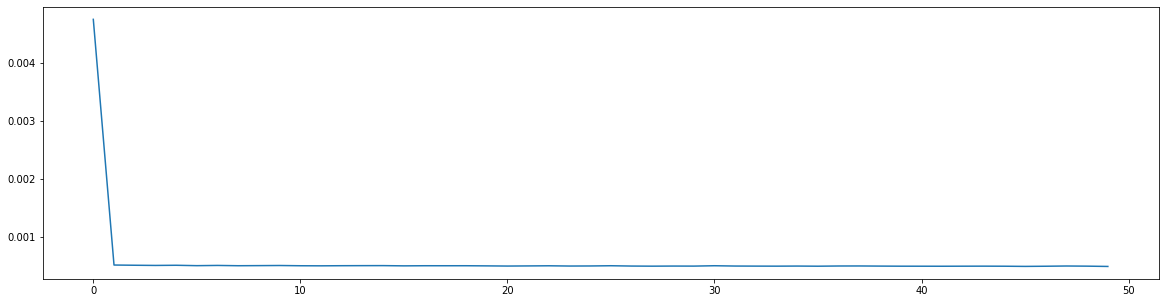

In [99]:
plt.figure(figsize=(20,5))
plt.plot(history.history["root_mean_squared_error"])
plt.figure(figsize=(20,5))
plt.plot(history.history["loss"])
plt.show()

In [ ]:
#3rd Station

In [100]:
# 2969101
# 2969100

test_new_x = np.asarray(all_data["6340140"]["data_x"])
test_new_y = np.asarray(all_data["6340140"]["data_y"])

test_new_y = np.asarray(test_new_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_new_x = scaler.fit_transform(test_new_x)
test_new_y = scaler.fit_transform(test_new_y)
test_new_x = test_new_x.reshape((test_new_x.shape[0], test_new_x.shape[1], 1))

results = model.predict(test_new_x)

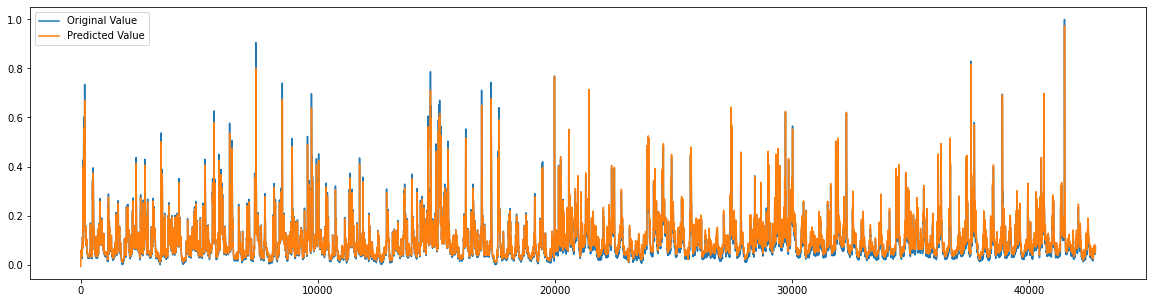

In [101]:
plt.figure(figsize=(20,5))
# plt.plot([i for i in range(len(y_test))], y_test)
plt.plot([i for i in range(len(test_new_y))], test_new_y,label='Original Value')
plt.plot([i for i in range(len(results))], results, label='Predicted Value')
plt.legend()
plt.show()

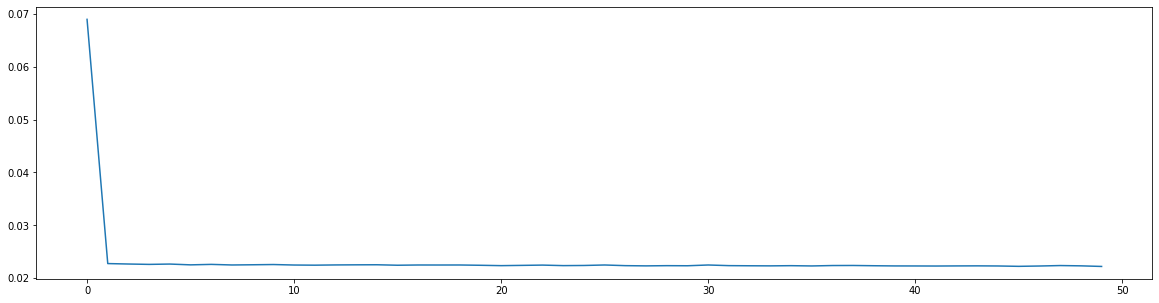

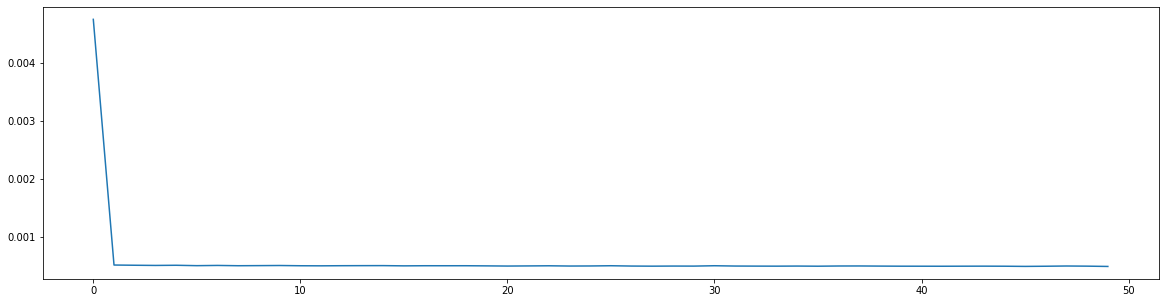

In [102]:
plt.figure(figsize=(20,5))
plt.plot(history.history["root_mean_squared_error"])
plt.figure(figsize=(20,5))
plt.plot(history.history["loss"])
plt.show()

In [ ]:
# Random Forest

In [ ]:
# 1st station

In [105]:
from sklearn.metrics import confusion_matrix

In [198]:
new_data_x = all_data["6233250"]["data_x"]
new_data_y = all_data["6233250"]["data_y"]

In [199]:
new_data_y = np.asarray(new_data_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
new_data_x = scaler.fit_transform(new_data_x)
new_data_y = scaler.fit_transform(new_data_y)
X_train, X_test, y_train, y_test = train_test_split(new_data_x, new_data_y, test_size = 0.20)
#X_train = np.asarray(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = np.asarray(y_train)
# = np.asarray(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = np.asarray(y_test)

In [170]:
from sklearn.metrics import f1_score

In [203]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train.ravel())
y_pred = regressor.predict(X_test)
training_prediction = regressor.predict(X_train)

In [202]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.01603314625981285
Mean Squared Error: 0.0005976126036150928
Root Mean Squared Error: 0.02444611632990183


In [209]:
#print(precision_score(y_test, y_pred,average = 'macro'))

In [134]:
#Precision_score =  f1_score(y_test,y_pred)

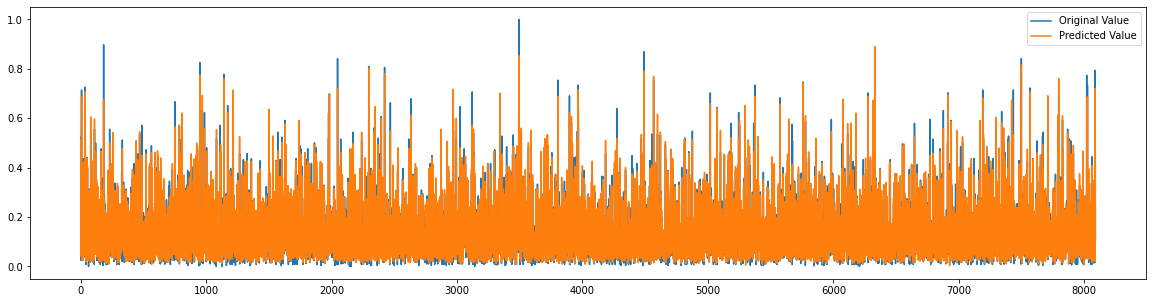

In [208]:
plt.figure(figsize=(20,5))
plt.plot([i for i in range(len(y_test))], y_test, label='Original Value')
# plt.plot([i for i in range(len(test_new_y))], test_new_y)
plt.plot([i for i in range(len(y_pred))], y_pred, label='Predicted Value')
plt.legend()
plt.show()

In [ ]:
#Random Forest Station 2

In [210]:
new_data_x = all_data["6233780"]["data_x"]
new_data_y = all_data["6233780"]["data_y"]

In [211]:
new_data_y = np.asarray(new_data_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
new_data_x = scaler.fit_transform(new_data_x)
new_data_y = scaler.fit_transform(new_data_y)
X_train, X_test, y_train, y_test = train_test_split(new_data_x, new_data_y, test_size = 0.20)
#X_train = np.asarray(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = np.asarray(y_train)
# = np.asarray(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = np.asarray(y_test)

In [212]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train.ravel())
y_pred = regressor.predict(X_test)
training_prediction = regressor.predict(X_train)

In [213]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.00416120690913488
Mean Squared Error: 0.0001934478714482269
Root Mean Squared Error: 0.013908553894931956


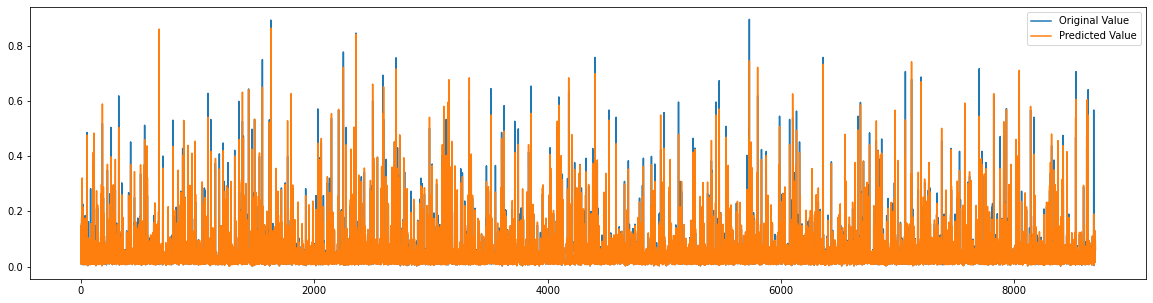

In [214]:
plt.figure(figsize=(20,5))
plt.plot([i for i in range(len(y_test))], y_test, label='Original Value')
# plt.plot([i for i in range(len(test_new_y))], test_new_y)
plt.plot([i for i in range(len(y_pred))], y_pred, label='Predicted Value')
plt.legend()
plt.show()

In [ ]:
#3rd Station

In [215]:
new_data_x = all_data["6340140"]["data_x"]
new_data_y = all_data["6340140"]["data_y"]

In [216]:
new_data_y = np.asarray(new_data_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
new_data_x = scaler.fit_transform(new_data_x)
new_data_y = scaler.fit_transform(new_data_y)
X_train, X_test, y_train, y_test = train_test_split(new_data_x, new_data_y, test_size = 0.20)
#X_train = np.asarray(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = np.asarray(y_train)
# = np.asarray(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = np.asarray(y_test)

In [217]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train.ravel())
y_pred = regressor.predict(X_test)
training_prediction = regressor.predict(X_train)

In [218]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.0066463624208032345
Mean Squared Error: 0.0001923122759454555
Root Mean Squared Error: 0.013867670170055801


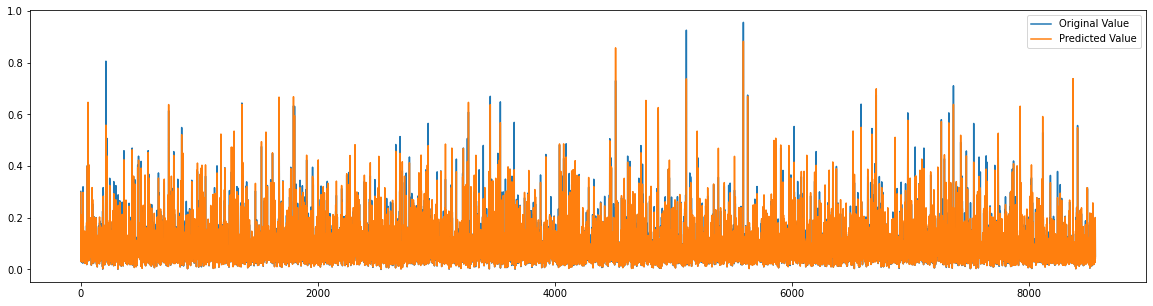

In [219]:
plt.figure(figsize=(20,5))
plt.plot([i for i in range(len(y_test))], y_test, label='Original Value')
# plt.plot([i for i in range(len(test_new_y))], test_new_y)
plt.plot([i for i in range(len(y_pred))], y_pred, label='Predicted Value')
plt.legend()
plt.show()